(content:references:transits_part3)=
# Planetary Transits Part 3: *Fitting a Transit Profile*

In this Section, we will present approaches for which we can fit the profile of a transiting planet using machine learning emulation techniques.

As before, we will use the [`batman`](https://lkreidberg.github.io/batman/) library to create our training data. 


In [24]:
import os
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import batman, torch, copy, corner
import scienceplots

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from copy import copy

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter1' / 'data'

plt.style.use('science')

fs = 18

In [ ]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 1.                       #orbital period
params.rp = 0.1                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 90.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.5, 0.5]      #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.025, 0.025, 100)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model

We will explore varying three parameters:

- Planet radius, $r_p$: The size of the planet influences the amount of light from the disk of the star blocked, where transit depth $\propto (r_p/R_{\star})$.

- Orbital semi-major axis, $a$: At larger orbital distances (for a given period), the planet moves faster across the stellar disk. At the same time, the range of inclination angles also becomes more restricted to near $90^{\circ}$.


- Inclination angle, $i$: Defines the orbital tilt relative to the observer's line of sight, determining the path (chord) the planet traces across the stellar disk during transit.

:::{admonition} Effect of orbital semi-major axis on the range of inclination angles
:class: dropdown

```{figure} images/transit_i_a.png
---
height: 220px
name: transit_i_a
---
An increase in $a$ results in a smaller range of $i$ in which a planet can still be observed to transit. Image credit: [CK-12](https://flexbooks.ck12.org/user:planetfinder/cbook/origins-and-the-search-for-life-in-the-universe/section/10.4/primary/lesson/the-transit-method/)
```
:::



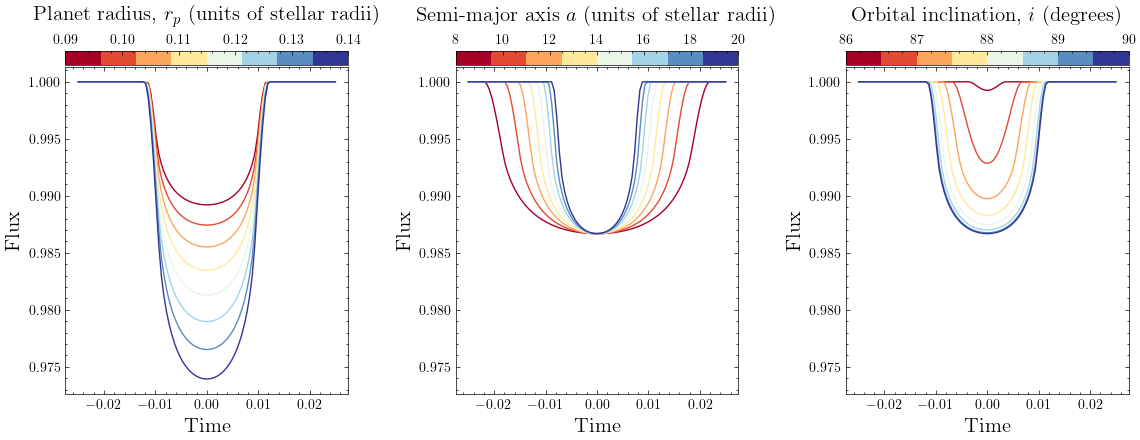

In [299]:
N = 8
cmap = mpl.colormaps['RdYlBu'].resampled(N)
rp_range = np.linspace(0.09, 0.14, N); a_range = np.linspace(8, 20, N); inc_range = np.linspace(86, 90, N)
norm_rp = Normalize(vmin=min(rp_range), vmax=max(rp_range))
norm_a = Normalize(vmin=min(a_range), vmax=max(a_range))
norm_inc = Normalize(vmin=min(inc_range), vmax=max(inc_range))

fig = plt.figure(figsize=(12, 5))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)

for i, rp in enumerate(rp_range):
    params_new = copy(params)
    params_new.rp = rp
    ax1.plot(t, m.light_curve(params_new), color = cmap(i / ((N) - 1)))
    
for i, a in enumerate(a_range):
    params_new = copy(params)
    params_new.a = a
    ax2.plot(t, m.light_curve(params_new), color = cmap(i / ((N) - 1)))

for i, inc in enumerate(inc_range):
    params_new = copy(params)
    params_new.inc = inc
    ax3.plot(t, m.light_curve(params_new), color = cmap(i / ((N) - 1)))
    
ax2.set_ylim(ax1.get_ylim()); ax3.set_ylim(ax1.get_ylim()); 

ax1.set_xlabel('Time', fontsize=fs-3); ax2.set_xlabel('Time', fontsize=fs-3); ax3.set_xlabel('Time', fontsize=fs-3)
ax1.set_ylabel('Flux', fontsize=fs-3); ax2.set_ylabel('Flux', fontsize=fs-3); ax3.set_ylabel('Flux', fontsize=fs-3)

sm = cm.ScalarMappable(cmap=cmap, norm=norm_rp)
sm.set_array(N)
cbar = fig.colorbar(sm, ax=ax1, orientation='horizontal', pad=0.005,location='top')
cbar.set_label('Planet radius, $r_p$ (units of stellar radii)', fontsize=fs-3, labelpad=10)
cbar.ax.xaxis.set_ticks_position('top')  
cbar.ax.xaxis.set_label_position('top')

sm = cm.ScalarMappable(cmap=cmap, norm=norm_a)
sm.set_array(N)
cbar = fig.colorbar(sm, ax=ax2, orientation='horizontal', pad=0.005,location='top')
cbar.set_label('Semi-major axis $a$ (units of stellar radii)', fontsize=fs-3, labelpad=10)
cbar.ax.xaxis.set_ticks_position('top') 
cbar.ax.xaxis.set_label_position('top')

sm = cm.ScalarMappable(cmap=cmap, norm=norm_inc)
sm.set_array(N)
cbar = fig.colorbar(sm, ax=ax3, orientation='horizontal', pad=0.005,location='top')
cbar.set_label('Orbital inclination, $i$ (degrees)', fontsize=fs-3, labelpad=10)
cbar.ax.xaxis.set_ticks_position('top')  
cbar.ax.xaxis.set_label_position('top')

plt.tight_layout(pad=2.5)
plt.show() 

Characterizing these parameters for an observed transiting planetary system will provide us insights into the orbital architecture and physical properties of the planet. To do this, we will sample across a range of input parameters $\theta = (r_p, a, i)$, simulate transits, and match them to observed light curves. This is the **forward modeling** approach.   

In this exercise, the `batman` library provides a very fast and convenient way of simulating transit profiles on the fly. Real physical simulations, however, require far more complexity over the idealized scenarios shown here are thus expensive to compute on demand. Here, we discuss two ways to use machine learning to speed up the forward modeling process.

## Emulation for Forward Modeling

An emulator is a machine learning model (e.g., a neural network) that serves as a surrogate generative function for complex simulations. Instead of running computationally expensive simulations each time new data is needed, the emulator is pre-trained to replicate their outputs. This shifts the computational burden to the training phase, allowing the emulator to generate high-fidelity approximations of the simulations at a fraction of the cost during inference. 

In this exercise, we will attempt to emulate the transits simulated by `batman` using a simple multi-layer perceptron network. Let's first define a prior function that allows us to easily sample from a range of parameters $\theta$:

In [302]:
from sbi.utils import BoxUniform
from torch import Tensor

class TransitPrior:
    def __init__(self, lower: Tensor, upper: Tensor, return_numpy: bool = False):
        self.lower = lower
        self.upper = upper
        self.dist = BoxUniform(lower, upper)
        self.return_numpy = return_numpy

    def sample(self, sample_shape=torch.Size([])):
        """Draw samples from the prior."""
        samples = self.dist.sample(sample_shape)
        
        return samples.numpy() if self.return_numpy else samples

    def log_prob(self, values):
        if self.return_numpy:
            values = torch.as_tensor(values)

        log_probs = self.dist.log_prob(values)

        return log_probs.numpy() if self.return_numpy else log_probs
    
## Define prior upper and lower limits here
t_prior = TransitPrior(lower = torch.Tensor([0.09, 8, 86]), upper = torch.Tensor([0.14, 20, 90]))

We may now sample from the `TransitPrior` object to obtain values uniformly sampled from the 3D hyperrectangle specified by the boundaries we've set.

In [303]:
t_prior.sample((5,))

tensor([[ 0.1189, 13.4565, 86.1350],
        [ 0.1098, 10.0750, 87.8942],
        [ 0.1205, 10.1830, 88.5022],
        [ 0.1373, 14.8661, 88.1728],
        [ 0.1105, 10.0352, 86.1010]])

Next, we define a simulator function, that accepts our sampled values of $\theta$ and modifies `batman`'s TransitModel accordingly.

In [304]:
def transit_simulator(theta):
    params_new = copy(params)

    params_new.rp = theta.squeeze()[0]
    params_new.a = theta.squeeze()[1]
    params_new.inc = theta.squeeze()[2]
    
    return m.light_curve(params_new)

Here are a few samples drawn from `t_prior`:

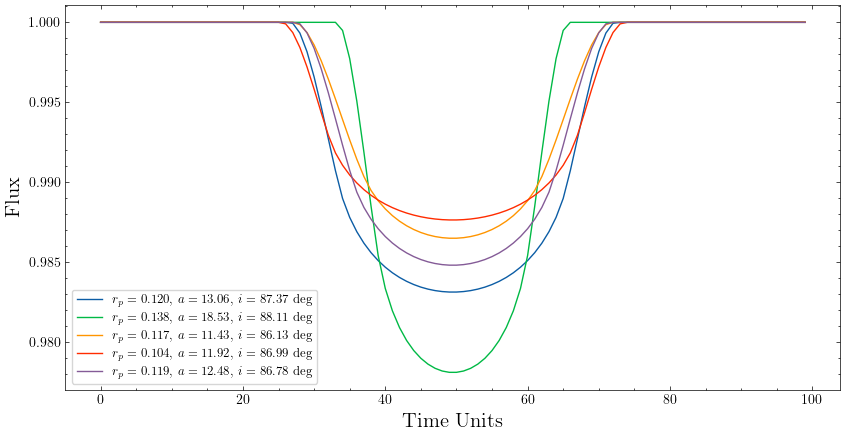

In [305]:
fig = plt.figure(figsize=(10, 5));
for i in range(5):
    theta = t_prior.sample((1,)).data.cpu().numpy().squeeze(); 
    plt.plot(transit_simulator(theta), label = f'$r_p={theta[0]:.3f}$, $a={theta[1]:.2f}$, $i={theta[2]:.2f}$ deg')
    plt.xlabel('Time Units', fontsize=fs-3); plt.ylabel('Flux', fontsize=fs-3)
    plt.legend( prop={'size': fs-9}, frameon=True)
plt.show()

Now we define the multi-layer perceptron to be trained using an Adam optimizer:

In [306]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torchinfo import summary

class TransitEmulator(nn.Module):

    def __init__(self):
        super(TransitEmulator, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            *[nn.Sequential(nn.Linear(128, 128), nn.ReLU()) for _ in range(7)],
            nn.Linear(128, 100) 
        )
        
    def normalize(self, x):
        x_ = x.detach().clone()

        if len(x_.size()) > 1:  
            x_[:,1] = x_[:,1]/10.
            x_[:,2] = 90. - x_[:,2]
        else:
            x_[1] = x_[1]/10.
            x_[2] = 90. - x_[2]
        return x_

    def forward(self, x):
        return self.layers(self.normalize(x))
    
model = TransitEmulator(); optimizer = Adam(model.parameters(), lr=1e-3)
summary(model, input_size=(1, torch.Tensor(theta).size()[0]))

Layer (type:depth-idx)                   Output Shape              Param #
TransitEmulator                          [1, 100]                  --
├─Sequential: 1-1                        [1, 100]                  --
│    └─Linear: 2-1                       [1, 128]                  512
│    └─ReLU: 2-2                         [1, 128]                  --
│    └─Sequential: 2-3                   [1, 128]                  --
│    │    └─Linear: 3-1                  [1, 128]                  16,512
│    │    └─ReLU: 3-2                    [1, 128]                  --
│    └─Sequential: 2-4                   [1, 128]                  --
│    │    └─Linear: 3-3                  [1, 128]                  16,512
│    │    └─ReLU: 3-4                    [1, 128]                  --
│    └─Sequential: 2-5                   [1, 128]                  --
│    │    └─Linear: 3-5                  [1, 128]                  16,512
│    │    └─ReLU: 3-6                    [1, 128]                  --
│ 

We will perform a quick training over the emulator over 5000 epochs, which should provide us with a decent level of accuracy.

```{note}
Notice the normalization of the input $\theta$ being passed to `TransitEmulator' as well as the target light curves.  Investigate the necessity of these normalizations and potential improvements. 
```

In [307]:
criterion = torch.nn.MSELoss()
num_epochs = 10000; batch_size = 128

model.train()
train_cumulative_loss = []

for epoch in range(num_epochs): 
    epoch_loss = 0
    
    train_x = t_prior.sample((batch_size,))
    train_y = torch.Tensor(np.array([transit_simulator(samp) for samp in train_x])).cuda()
    
    # remove samples whose batman profile has no dimming
    train_x_inp = train_x.cuda()[torch.sum(train_y, dim=1) != train_y.size()[1]]
    train_y = train_y[torch.sum(train_y, dim=1) != train_y.size()[1]] 
    
    optimizer.zero_grad() 
    output = model(train_x_inp)
    loss = criterion(output, 1000*(train_y-1)); loss.backward(); optimizer.step()

    epoch_loss += loss.item(); train_cumulative_loss.append(loss.item())
    
    if epoch % 1000 == 0: print(f'Epoch {epoch}, Train Loss: {epoch_loss:.4f}')

Epoch 0, Train Loss: 86.4594
Epoch 1000, Train Loss: 0.8653
Epoch 2000, Train Loss: 0.0796
Epoch 3000, Train Loss: 0.1673
Epoch 4000, Train Loss: 0.0789
Epoch 5000, Train Loss: 0.1867
Epoch 6000, Train Loss: 0.0259
Epoch 7000, Train Loss: 0.0509
Epoch 8000, Train Loss: 0.0233
Epoch 9000, Train Loss: 0.0176


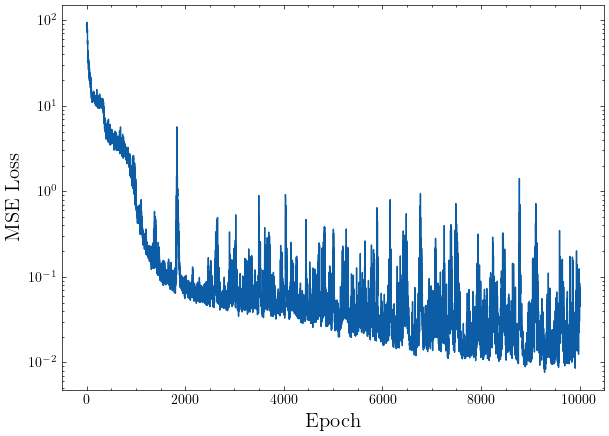

In [308]:
fig = plt.figure(figsize=(7,5))
plt.semilogy(np.arange(num_epochs), train_cumulative_loss)
plt.xlabel('Epoch', fontsize=fs-3); plt.ylabel('MSE Loss', fontsize=fs-3); plt.show()

We can perform a quick 'eye-test' of our emulator by sampling $\theta$ from the prior, pushing it through the network, and comparing its predictions with the corresponding `batman` solution.

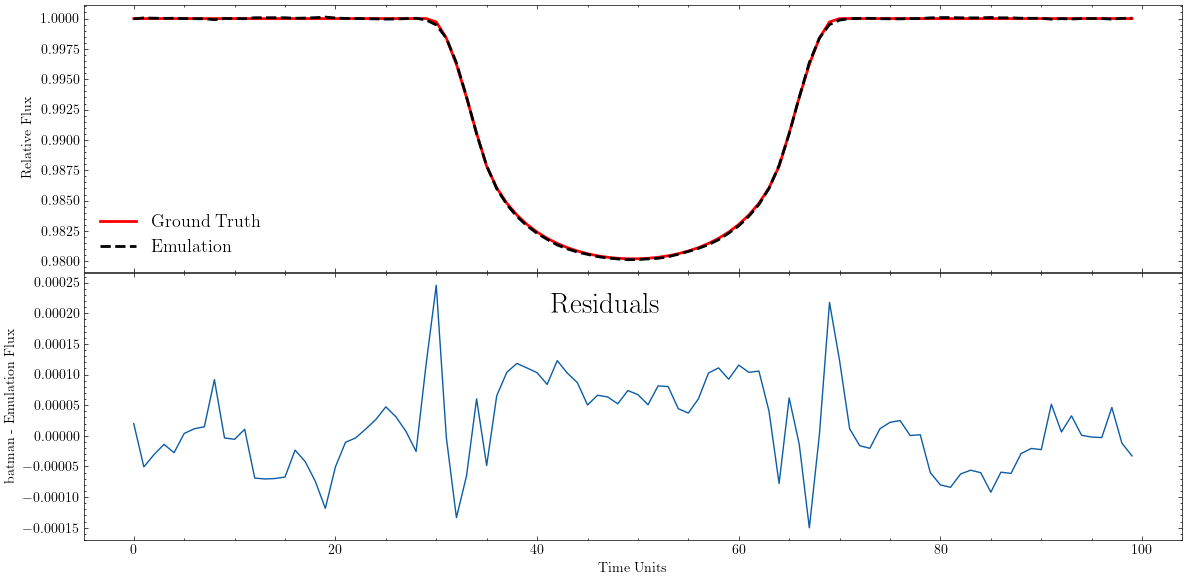

In [309]:
theta_ = t_prior.sample((1,))
batman_sol = transit_simulator(theta_)
emulator_sol = model(theta_.cuda()).data.cpu().numpy().squeeze()

fig = plt.figure(figsize=(12,6)); ax1, ax2= fig.add_subplot(211), fig.add_subplot(212)
ax1.plot(batman_sol, label = 'Ground Truth', c='r', lw=2); ax1.plot(1 + emulator_sol/1000, c='k',lw=2, label = 'Emulation', ls='--')
ax2.plot(batman_sol - (1 + emulator_sol/1000)); ax1.set_xticklabels([]); ax2.set_xlabel('Time Units');
ax2.set_ylabel('batman - Emulation Flux'); ax1.set_ylabel('Relative Flux')
ax1.legend(prop={'size': fs-5}); ax2.text(x=0.425, y=0.85, transform=ax2.transAxes, s='Residuals', fontsize=fs+3)
plt.tight_layout(h_pad=0.1); plt.show()

The emulator performs reasonably well, but struggles slightly with reproducing the ingress and egress features, in particular where the edges are most pronounced in the transit profile.

```{admonition} Ingress/Egress
:class: seealso
Consider experimenting with different network architectures that may better replicate sharp features, just as those shown by the transit ingress/egress.
```

With the trained emulator, we can now calculate posterior distributions using Bayesian inference:

$P(\theta | D) \propto P(\theta)\mathcal{L}(D|\theta)$

- The prior $P(\theta)$ is available to us via the `TransitPrior` object.
- Samples generated from the emulator allow us to calculate $\mathcal{L}(D|\theta)$, the likelihood of the data given $\theta$.

We will use the `emcee` library to sample our posterior distribution. First, we define functions encapsulating our prior and likelihood into a log probability function, as outlined in the [emcee tutorials]( https://emcee.readthedocs.io/en/develop/user/line/).

In [310]:
import emcee

def gaussian_log_likelihood(x, pred, sigma_squared=1):
    log_likelihood = -0.5 * np.sum((x - pred) ** 2 / sigma_squared + np.log(sigma_squared))
    return log_likelihood

def log_prior(theta):
    return -t_prior.log_prob(theta).data.cpu().numpy()

def log_probability(theta, x):
    theta = torch.Tensor(theta)
    lp = log_prior(theta)
    pred = model(theta.cuda()).data.cpu().numpy()
    if not np.isfinite(lp):
        return -np.inf
    return lp + gaussian_log_likelihood(x, pred)   # log (P(theta) x L(D|theta))

We will determine the posterior distribution of the emulator when matching its predictions to observed data. Here, the data is the `batman_sol` above.
```{important}
Notice the re-normalization of `batman_sol` when passing it into the likelihood function. It's important to keep track of where transformations are being applied in the workflow!
```


```{note}

In the exercise below, we set the initial condition equal to `theta_`, the prior values that we **know** correspond to `batman_sol`. This makes the example rather contrived, because in practice we would certainly not know beforehand where are good parts of the parameter space to sample. Feel free, however, to modify `pos` to begin at other points in parameter space instead. The resulting posterior distribution should remain similar.
```

In [311]:
xo = t_prior.sample((1,)).data.cpu().numpy().squeeze() 

ndim, nwalkers = 3, 100
draws = 1000

pos = [np.array( xo ) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(1000*(batman_sol-1),))
sampler.run_mcmc(pos, 1000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:49<00:00,  9.16it/s]


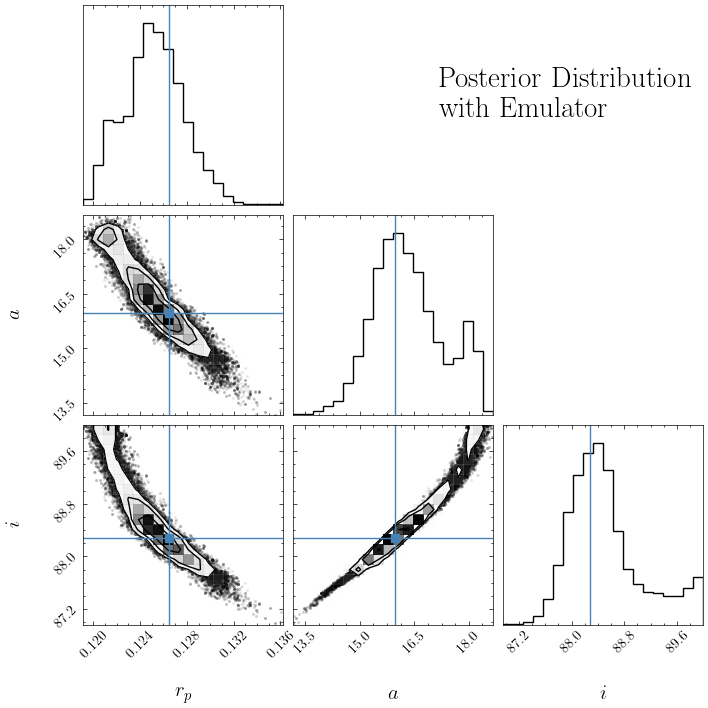

In [312]:
labels = ['$r_p$', '$a$', '$i$']

samples = sampler.chain[:, -800:, :].reshape((-1, ndim))  # obtain samples from emcee
fig = corner.corner(samples, truths=theta_.data.cpu().numpy().squeeze(),
                    labels = labels, figsize=(12, 12)) 
for ax in fig.axes:
    ax.xaxis.label.set_size(fs-3) 
    ax.yaxis.label.set_size(fs-3)
fig.text(x=0.6, y = 0.8, s='Posterior Distribution\nwith Emulator', fontsize=fs+3)
plt.show()

The blue lines above represent $\theta$, or the 'ground truth'. Using these samples from the posterior distribution, let's visualize how the transits appear using our emulator and using the true simulation as a sanity check.


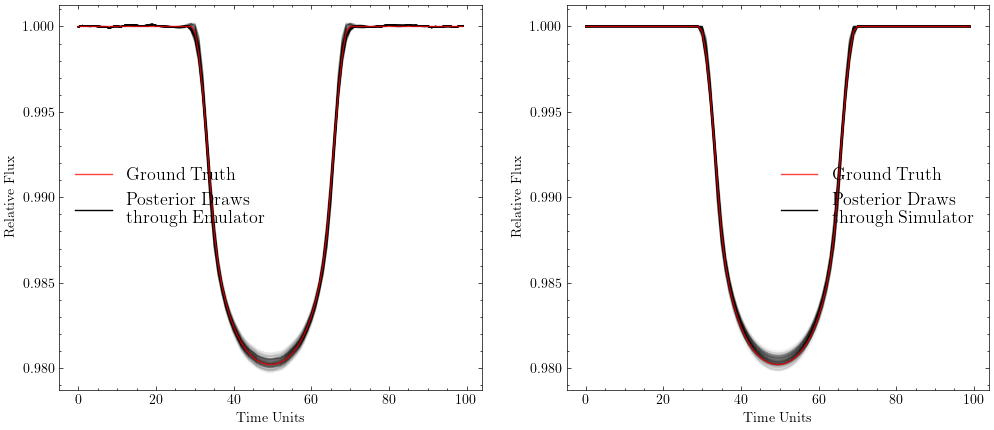

In [313]:
fig = plt.figure(figsize=(12, 5))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)

for s in samples[::500]:
    ax2.plot(transit_simulator(s), c='k', alpha=0.05)

    pred = model(torch.Tensor(s).cuda()).data.cpu().numpy()
    ax1.plot(1+ pred/1000., c='k', alpha=0.05)
    
ax1.plot(transit_simulator(theta_), c='r', alpha=0.75, label='Ground Truth')
ax2.plot(transit_simulator(theta_), c='r', alpha=0.75, label='Ground Truth')
ax1.plot([],[], label='Posterior Draws\nthrough Emulator', c='k'); ax2.plot([],[], label='Posterior Draws\nthrough Simulator', c='k')
ax1.set_ylabel('Relative Flux'); ax1.set_xlabel('Time Units')
ax2.set_ylabel('Relative Flux'); ax2.set_xlabel('Time Units')
ax1.legend(prop={'size': fs-5}); ax2.legend(prop={'size': fs-5})
ax2.set_ylim(ax1.get_ylim())
plt.show()


The differences between these two scenarios show how accurately the emulator acts as a surrogate to the simulator. The emulator creates transits with a smaller dispersion that what is actually simulated, showing that the emulator's mapping from observations to data is still relatively imprecise.

## Neural Likelihood Inference (NLE)

In this exercise, the calculation of the likelihood is trivially simple. In applications, there may be cases whereby such calculations are infeasible, typically when the likelihood involves integrating over a complex and/or high-dimensional forward model. Complex models may include those that are autoregressive in nature (e.g., time series), or those with latent variables (e.g., Gaussian Mixture Model) for which evaluation of a likelihood means calculating over all possible configurations.

Instead of directly computing an explicit likelihood, we can use **Neural Likelihood Inference (NLE)** to estimate the distribution $\mathcal{L}(D|\theta)$. We will be using NLE as implemented by the [`sbi`](https://sbi-dev.github.io/) library.


In [314]:
from sbi.utils import process_prior
from sbi.inference import SNLE, simulate_for_sbi

transit_prior, *_ = process_prior(t_prior)  # Wrapping the prior
inference = SNLE(prior=transit_prior, device='cpu')

/home/marc/anaconda3/lib/python3.8/site-packages/sbi/utils/user_input_checks_utils.py:389: UserWarning: No prior bounds were passed, consider passing lower_bound
            and / or upper_bound if your prior has bounded support.
  warnings.warn(
/home/marc/anaconda3/lib/python3.8/site-packages/sbi/utils/user_input_checks_utils.py:69: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  warnings.warn(
/home/marc/anaconda3/lib/python3.8/site-packages/sbi/utils/user_input_checks_utils.py:80: UserWarning: Prior is lacking variance attribute, estimating prior variance from
                samples...
  warnings.warn(


The objective of NLE is to model the likelihood $p(x|\theta)$ using a conditional neural density estimator $q_{\phi}(x|\theta)$

$\mathbb{E}_{\tilde{p}(\theta, x)} \left[ \log q_\phi(x | \theta) \right] = - \mathbb{E}_{\tilde{p}(\theta)} \left[ \text{KL} \left( p(x | \theta) \parallel q_\phi(x | \theta) \right) \right] + \text{const}$


Maximizing the total log-likelihood (left-hand side) is equivalent to minimizing the KL divergence between the true likelihood $p(x | \theta)$ and the neural likelihood estimator $q_\phi(x | \theta)$.

To generate pairs $(x, \theta)$ for `sbi`, we introduce a wrapper to simulate transits using `batman` that outputs tensors instead of `numpy` arrays.

In [315]:
def transit_simulator_t(theta):
    params_new = copy(params)

    params_new.rp = theta.squeeze()[0]
    params_new.a = theta.squeeze()[1]
    params_new.inc = theta.squeeze()[2]
    
    return torch.Tensor(m.light_curve(params_new)).unsqueeze(0)


theta, x = simulate_for_sbi(transit_simulator_t, transit_prior, 20000)

Running 20000 simulations.:   0%|          | 0/20000 [00:00<?, ?it/s]

We follow the syntax of `sbi` and to train a likelihood estimator.

In [316]:
likelihood_estimator = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 213 epochs.

## Using NLE to estimate a posterior distribution

We can output a 'potential function' from `sbi`, which is simply $\log(P(\theta)\mathcal{L}(D|\theta))$. We have to pass in an input observation, which here would be the sample `batman` curve analyzed above.

```{note}
The output of the potential function is identical to the output of the manually-defined `log_probability` function when sampling with the emulator earlier in this exercise.
```



In [317]:
from sbi.inference import likelihood_estimator_based_potential

observation = transit_simulator(theta_)

potential_fn, _ = likelihood_estimator_based_potential(
    likelihood_estimator, t_prior, observation
)

/home/marc/anaconda3/lib/python3.8/site-packages/sbi/utils/sbiutils.py:646: UserWarning: The passed prior has no support property, transform will be
                constructed from mean and std. If the passed prior is supposed to be
                bounded consider implementing the prior.support property.
  warnings.warn(
/home/marc/anaconda3/lib/python3.8/site-packages/sbi/utils/sbiutils.py:680: UserWarning: The passed prior has no mean or stddev attribute, estimating
                    them from samples to build affimed standardizing transform.
  warnings.warn(


Running the potential function at the same $\theta$ that generated the observation should give the maximum log-likelihood, as opposed to any other randomly sampled $\theta$ value.

In [318]:
potential_fn(theta_), potential_fn(theta[22])

(tensor([1507.5471], grad_fn=<AddBackward0>),
 tensor([-465371.8750], grad_fn=<AddBackward0>))

We can use this trained NLE's potential function now as an objective function in MCMC.

In [319]:
def potential_fn_npy(theta):
    return potential_fn(torch.Tensor(theta)).data.cpu().numpy()

ndim, nwalkers = theta_.size()[1], 100
draws = 1000

pos = [np.array( theta[40].data.cpu().numpy()) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler_nle = emcee.EnsembleSampler(
    nwalkers, ndim, potential_fn_npy)

sampler_nle.run_mcmc(pos, 2000, progress=True);


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:34<00:00,  4.40it/s]


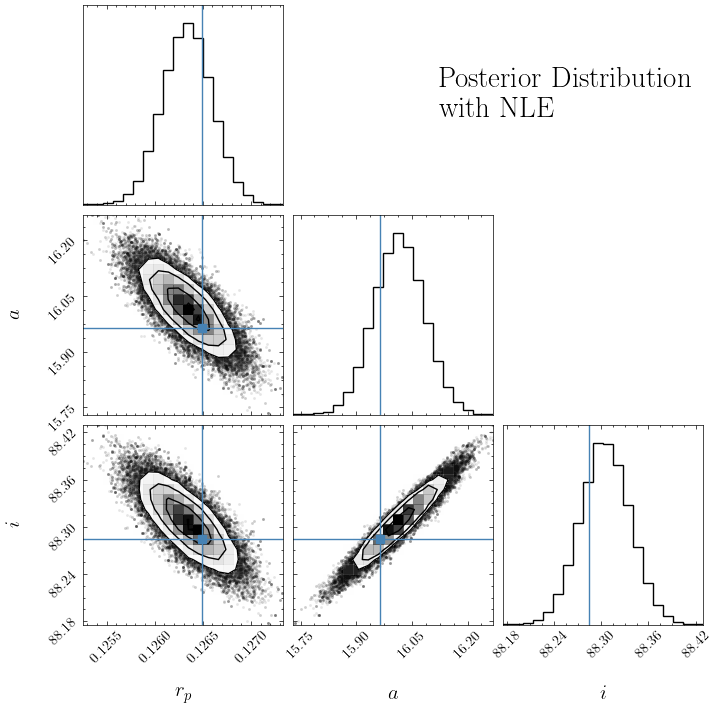

In [320]:
labels = ['$r_p$', '$a$', '$i$']

samples_nle = sampler_nle.chain[:, -800:, :].reshape((-1, ndim))  # obtain samples from emcee
fig = corner.corner(samples_nle, truths =theta_.data.cpu().numpy().squeeze(),
                   labels=labels, figsize=(12, 12)) # plotting the samples in a Corner plot!|
for ax in fig.axes:
    ax.xaxis.label.set_size(fs-3) 
    ax.yaxis.label.set_size(fs-3)
fig.text(x=0.6, y = 0.8, s='Posterior Distribution\nwith NLE', fontsize=fs+3)
plt.show()

## Comparing outputs from emulation versus NLE

The clear winner from this simple comparison is NLE. Differences in architecture aside, the NLE approach is not contingent on the accuracy of a reconstruction process, which is what the emulation process requires.

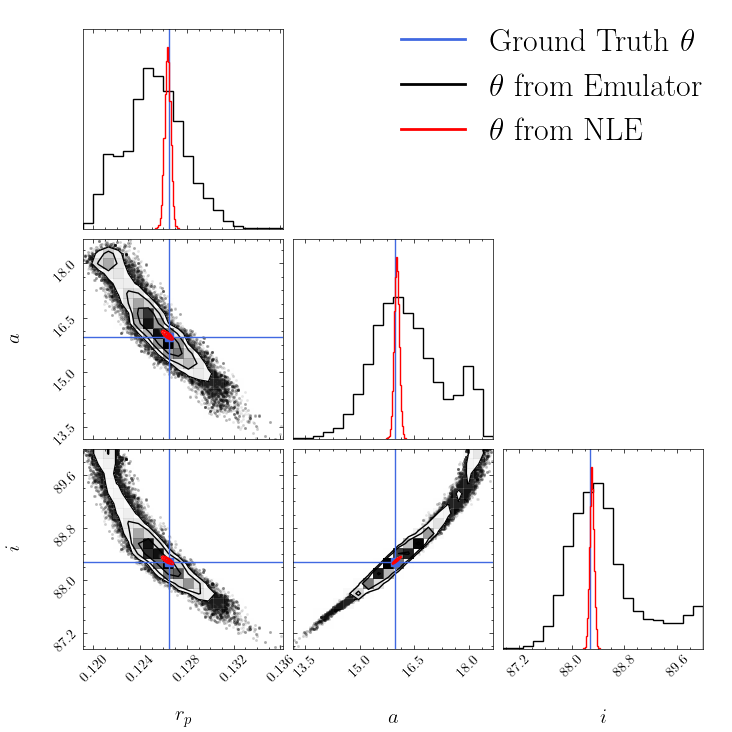

In [321]:
labels = ['$r_p$', '$a$', '$i$']
fig = corner.corner(samples, truths=theta_.data.cpu().numpy().squeeze(),
                    labels = labels, figsize=(12, 12), truth_color="royalblue")
corner.corner(samples_nle, color='red', fig = fig)

for ax in fig.axes:
    ax.xaxis.label.set_size(fs-3) 
    ax.yaxis.label.set_size(fs-3)
axes = np.array(fig.axes).reshape((len(labels), len(labels)))
handles = [plt.Line2D([0], [0], color='royalblue', lw=2, label=r'Ground Truth $\theta$'),
           plt.Line2D([0], [0], color='k', lw=2, label=r'$\theta$ from Emulator'),
           plt.Line2D([0], [0], color='red', lw=2, label=r'$\theta$ from NLE')]
fig.legend(handles=handles, loc="upper right", fontsize=fs+5, frameon=False)
plt.show()

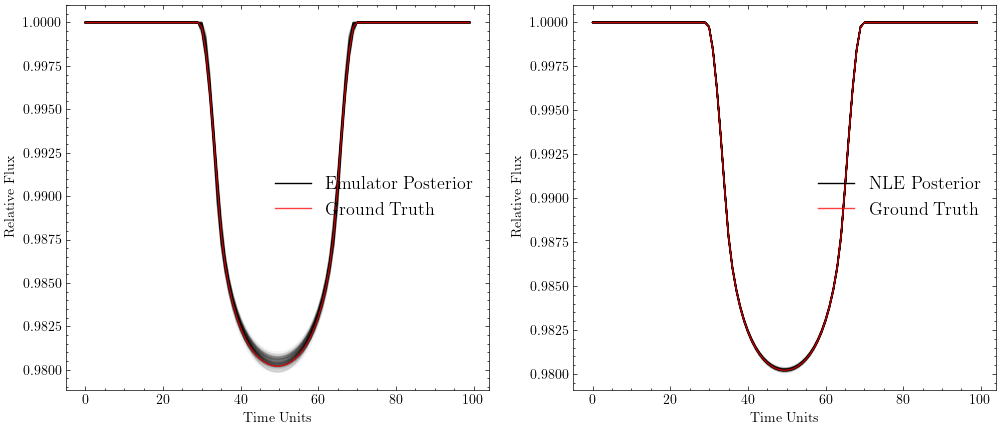

In [322]:
fig = plt.figure(figsize=(12,5))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
axlist = [ax1,ax2]

for s, s_ in zip(samples[::500], samples_nle[::500]):
    ax1.plot(transit_simulator(s), c='k', alpha=0.05)
    ax2.plot(transit_simulator(s_), c='k', alpha=0.05)

ax1.plot([],[], label='Emulator Posterior', c='k'); ax2.plot([],[], label='NLE Posterior', c='k')
for ax in axlist:
    ax.plot(transit_simulator(theta_), c='r', alpha=0.75, label='Ground Truth')
    ax.set_ylabel('Relative Flux'); ax.set_xlabel('Time Units')
    ax.legend(prop={'size': fs-5}); ax2.legend(prop={'size': fs-5})
plt.show()

## Application on real data: HD 209458


Let's apply our posterior inference tools on HD 209458, [the first extrasolar planet to have its planet detected by the transit method.](https://iopscience.iop.org/article/10.1086/312457) The discovery paper we reference here is  {cite}`Charb_2000`.

```{figure} images/hd209458.png
---
height: 500px
width: 750px
name: hd209458
---
Average transit of HD 209458 from its discovery paper.
```

We will examine observations of the star from TESS in Sector 56. Note the really deep transits that occur with a period of $<5$ days.


In [323]:
lc = pd.read_csv(data_folder_path /'HD209458_LC.txt', names=['Time','Flux'], delim_whitespace=True)
lc

,Time,Flux
0,2825.262051,1.000848
1,2825.262282,1.000873
2,2825.262514,1.001428
3,2825.262745,1.001210
4,2825.262977,1.000717
...,...,...
114775,2853.142934,0.999244
114776,2853.143166,1.000004
114777,2853.143397,0.999635
114778,2853.143629,0.999275


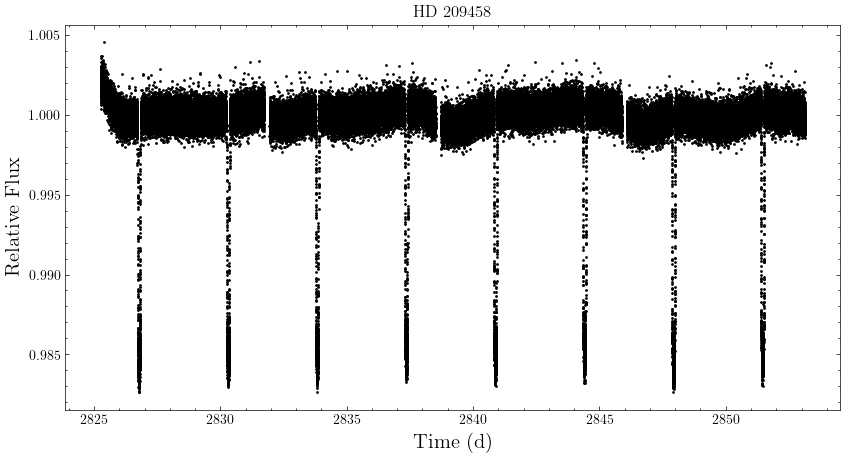

In [324]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(lc.Time, lc.Flux, s=1, c='k')
plt.xlabel('Time (d)', fontsize=fs-3); plt.ylabel('Relative Flux', fontsize=fs-3)
plt.title('HD 209458')
plt.show()

Following the steps in [](content:references:transits_part1), we will calculate the period of the transits using the Box Least-Squares Periodogram, and we will fold the light curve on this period to get an average transit.

In [325]:
from astropy.timeseries import BoxLeastSquares
import astropy.units as u

bls = BoxLeastSquares(lc.Time.values * u.day, lc.Flux*u.dimensionless_unscaled)
periodogram = bls.power(duration = 0.1* u.day, period = np.linspace(2, 5, 5000) * u.day)

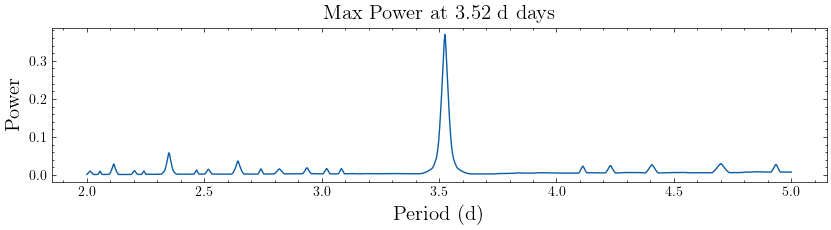

In [326]:
def plot_bls_spectrum(periodogram):
    plt.figure(figsize=(10, 2))
    plt.plot(periodogram.period, periodogram.power)
    plt.xlabel('Period (d)', fontsize=fs-3)
    plt.ylabel('Power', fontsize=fs-3)
    plt.title(f'Max Power at {periodogram.period[np.argmax(periodogram.power)]:.2f} days', fontsize=fs-3); plt.show()
    plt.show()
    
plot_bls_spectrum(periodogram)

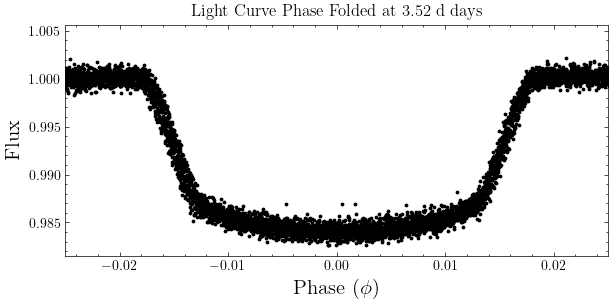

In [327]:
def plot_phase_folded(periodogram, xlim=(-0.5, 0.5)):
    centered_phase = np.mod(lc.Time - periodogram.transit_time[np.argmax(periodogram.power)].value, periodogram.period[np.argmax(periodogram.power)].value)/periodogram.period[np.argmax(periodogram.power)].value
    centered_phase[centered_phase > 0.5] -= 1
    plt.figure(figsize=(7, 3))
    plt.scatter(centered_phase, lc.Flux, s=3, c='k')
    plt.xlim(xlim); plt.xlabel('Phase $(\\phi)$', fontsize=fs-3); plt.ylabel('Flux', fontsize = fs-3)
    plt.title(f'Light Curve Phase Folded at {periodogram.period[np.argmax(periodogram.power)]:.2f} days');plt.show()
    return centered_phase
lc_phase = plot_phase_folded(periodogram, xlim=(-0.025, 0.025))

To get this transit into a format onto which we can apply our tools, we need to bin the light curve into an appropriate dimensionality.

```{important}
When the simulated light curves were generated with `batman`, we specified a period of 1 day and a time array of $t\in[-0.025, 0.025]$. Since the phase $\phi = (t\,\text{mod}P)/P$, we thus have $\phi\in[-0.025, 0.025]$.
```

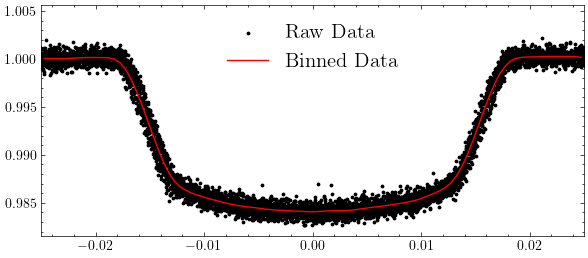

In [328]:
from scipy.stats import binned_statistic
import math
from astropy.convolution import convolve, Box1DKernel

phase_bins = np.linspace(-0.025, 0.025, 101)
median_tflux, phase_binedges, _ = binned_statistic(lc_phase, lc.Flux, statistic='mean', bins=phase_bins)
phase_grid = 0.5*(phase_binedges[1:] + phase_binedges[:-1])

median_tflux = convolve(median_tflux, Box1DKernel(math.ceil((4./ 1))) ,boundary='fill', 
                        fill_value=1.)

plt.figure(figsize=(7, 3))
plt.scatter(lc_phase, lc.Flux, s=3, c='k', label='Raw Data')
plt.plot(phase_grid, median_tflux, c='r', label='Binned Data')
plt.xlim(-0.025, 0.025); plt.legend(prop={'size': fs-3}); plt.show()


### Inference on HD 209458 using the emulator

In [329]:
xo = t_prior.sample((1,)).data.cpu().numpy().squeeze() # random start

ndim, nwalkers = 3, 100
draws = 1000

pos = [np.array( xo ) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler_obsemu = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(1000*(median_tflux-1),))
sampler_obsemu.run_mcmc(pos, 1000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.41it/s]


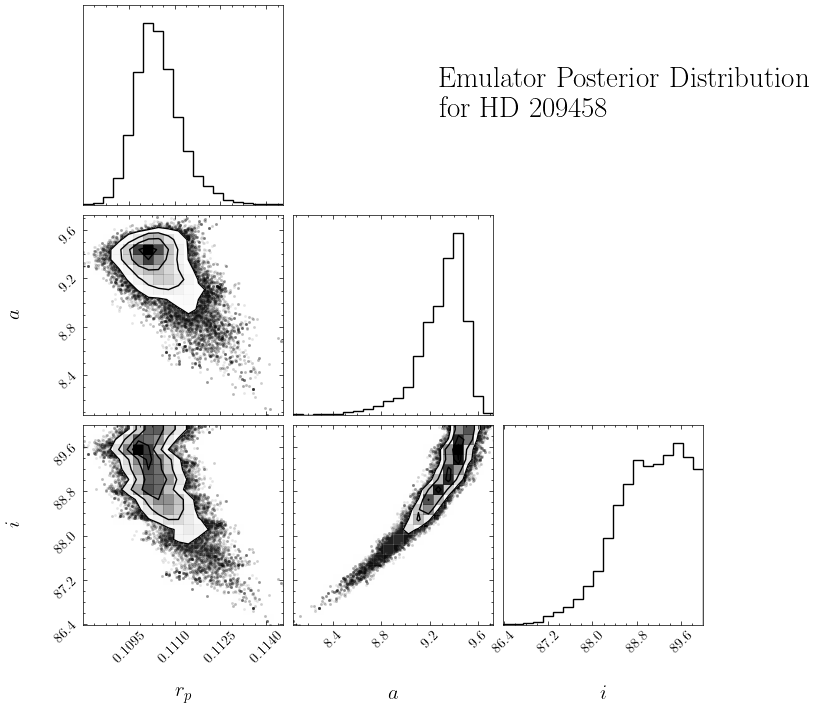

In [330]:
labels = ['$r_p$', '$a$', '$i$']

samples_obsemu = sampler_obsemu.chain[:, -800:, :].reshape((-1, ndim)) 
fig = corner.corner(samples_obsemu,
                    labels = labels, figsize=(12, 12)) 
for ax in fig.axes:
    ax.xaxis.label.set_size(fs-3) 
    ax.yaxis.label.set_size(fs-3)
fig.text(x=0.6, y = 0.8, s='Emulator Posterior Distribution\nfor HD 209458', fontsize=fs+3)
plt.show()

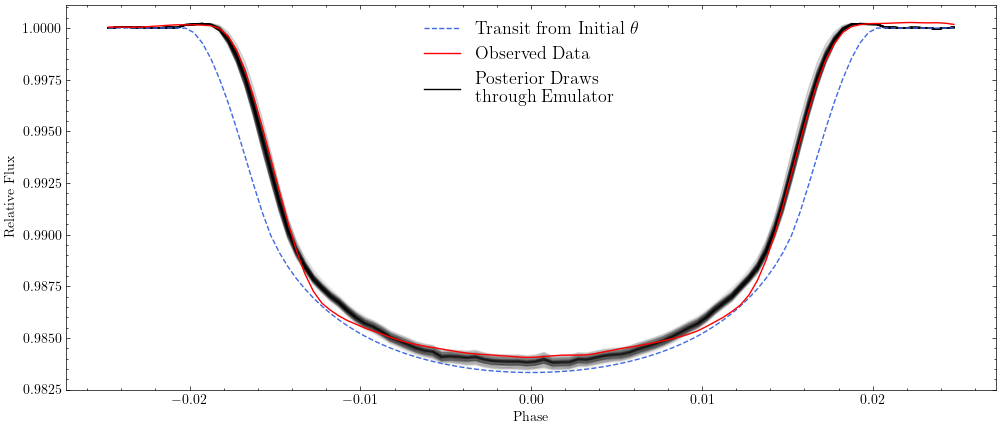

In [344]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

for s in samples_obsemu[::500]:
    pred = model(torch.Tensor(s).cuda()).data.cpu().numpy()
    ax1.plot(phase_grid, 1+ pred/1000., c='k', alpha=0.05)
ax1.plot(phase_grid, transit_simulator(np.array( xo )), c='royalblue', label='Transit from Initial $\\theta$', ls='--')
ax1.plot(phase_grid, median_tflux, c='r', label='Observed Data')
ax1.plot([],[], label='Posterior Draws\nthrough Emulator', c='k')
ax1.set_ylabel('Relative Flux'); ax1.set_xlabel('Phase')
ax1.legend(prop={'size': fs-5})
plt.show()

The emulator does a reasonable job at matching the observed transits, although there is some curvature near the bottom that is unaccounted for. This can potentially be fitted if we considered proper limb-darkening coefficients, as opposed to assuming a fixed and arbitrary value for them.

### Inference on HD 209458 using NLE

In [381]:
observation = median_tflux

potential_fn_obs, _ = likelihood_estimator_based_potential(
    likelihood_estimator, t_prior, observation
) # recall that likelihood_estimator = trained NLE model

def potential_fn_obs_npy(theta):
    return potential_fn_obs(torch.Tensor(theta)).data.cpu().numpy()

ndim, nwalkers = theta_.size()[1], 200
draws = 2000

pos = [np.array( theta[0].data.cpu().numpy()) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler_obsnle = emcee.EnsembleSampler(
    nwalkers, ndim, potential_fn_obs_npy, moves = emcee.moves.DESnookerMove())

sampler_obsnle.run_mcmc(pos, 2000, progress=True);


/home/marc/anaconda3/lib/python3.8/site-packages/sbi/utils/sbiutils.py:646: UserWarning: The passed prior has no support property, transform will be
                constructed from mean and std. If the passed prior is supposed to be
                bounded consider implementing the prior.support property.
  warnings.warn(
/home/marc/anaconda3/lib/python3.8/site-packages/sbi/utils/sbiutils.py:680: UserWarning: The passed prior has no mean or stddev attribute, estimating
                    them from samples to build affimed standardizing transform.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [13:56<00:00,  2.39it/s]


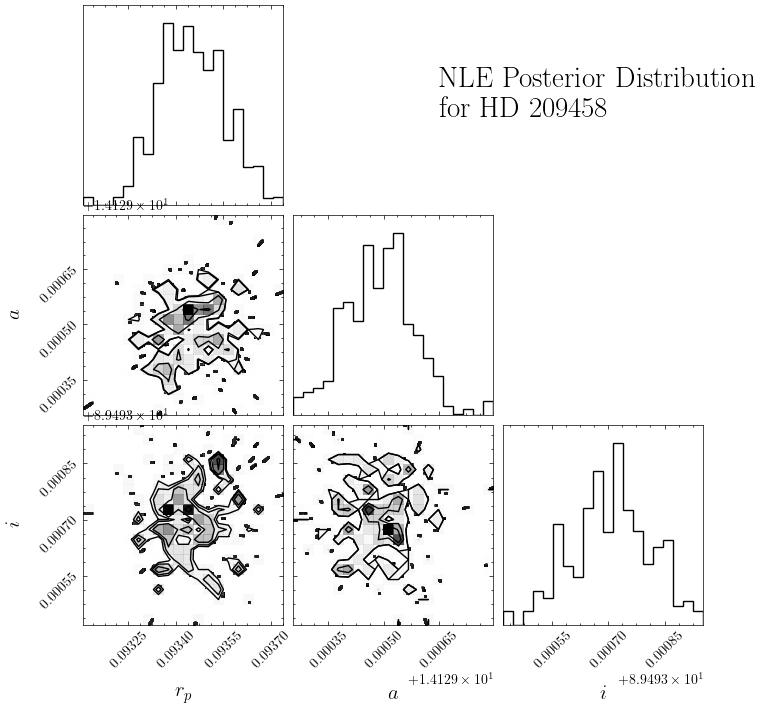

In [382]:
labels = ['$r_p$', '$a$', '$i$']

samples_obsnle = sampler_obsnle.chain[:, -800:, :].reshape((-1, ndim)) 
fig = corner.corner(samples_obsnle,
                    labels = labels, figsize=(12, 12)) 
for ax in fig.axes:
    ax.xaxis.label.set_size(fs-3) 
    ax.yaxis.label.set_size(fs-3)
fig.text(x=0.6, y = 0.8, s='NLE Posterior Distribution\nfor HD 209458', fontsize=fs+3)
plt.show()

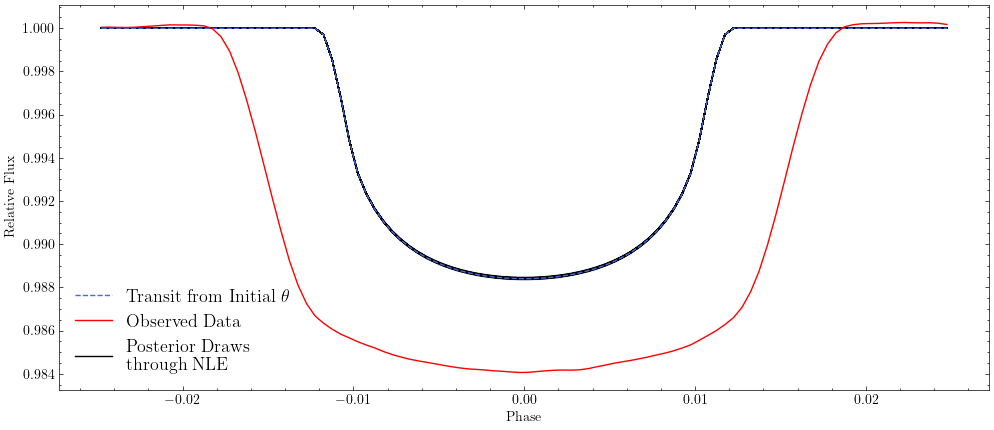

In [383]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

for s in samples_obsnle[::500]:
    ax1.plot(phase_grid, transit_simulator(s), c='k', alpha=0.05)
    
ax1.plot(phase_grid, transit_simulator(pos[0]), c='royalblue', label='Transit from Initial $\\theta$', ls='--')

ax1.plot(phase_grid, median_tflux, c='r', label='Observed Data')
ax1.plot([],[], label='Posterior Draws\nthrough NLE', c='k')
ax1.set_ylabel('Relative Flux'); ax1.set_xlabel('Phase')
ax1.legend(prop={'size': fs-5})
plt.show()

The sampling effectively never moves past the prior, symptomatic of a scenario whereby the NLE extrapolates poorly and provides a completely uninformative likelihood. Density estimation inherently depends on knowing the full support of $p(x∣\theta)p(x∣\theta)$, and we know the observed transit is indeed out-of-distribution (OOD).  The normalizing flows used in NLE may struggle with OOD examples as they rely on learning transformations of a base distribution (often Gaussian). If the training data did not cover the region well, the model is likely to assign zero probabilities density even to slightly OOD examples like these.

```{note}
Verify the behaviour of the predicted likelihoods from the NLE model on this observational target. 
```


For a simple example like this, the emulator is cheaper to train and is far more transparent in its output and sampling process, allowing users to quickly diagnose problems in the inference process. 


### Comparison with literature estimates


```{figure} images/hd209458_contour.png
---
height: 400px
width: 450px
name: hd209458_contour
---
Estimates of the transit properties of the planet HD 209458b from its discovery paper.
```

From the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu), HD 209458 has a radius of $R = 1.19 R_{\odot}$. Then, let's use the fact that $1R_{\odot} = 9.73116 R_J$.



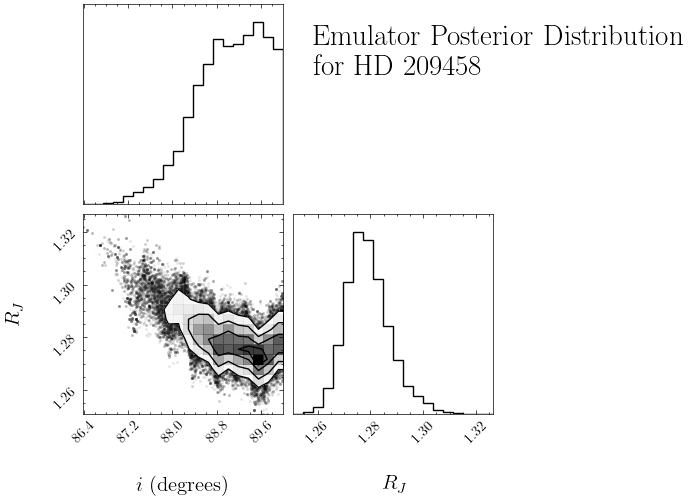

In [370]:
labels = ['$i$ (degrees)', '$R_J$']
samples_obsemu_comp = samples_obsemu[:, [0, 2]][:, ::-1]
samples_obsemu_comp[:,1] *= 1.19 * 9.73116   # x Rsol x Rjup

fig = corner.corner(samples_obsemu_comp,
                    labels = labels, figsize=(12, 12)) 
for ax in fig.axes:
    ax.xaxis.label.set_size(fs-3) 
    ax.yaxis.label.set_size(fs-3)
fig.text(x=0.6, y = 0.8, s='Emulator Posterior Distribution\nfor HD 209458', fontsize=fs+3)
plt.show()


`````{admonition} Exercise
Experiment with the following:

1. Implementing proper limb darkening coefficients to the `batman` model.
- This depends on the properties of its star (effective temperature and surface gravity). Look up the stellar properties from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu) and find the corresponding limb darkening coefficients [online](https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/A+A/600/A30). 


2. Including the limb darkening coefficients as free parameters to the transit model.


3. Consider using the Neural Posterior Estimation (NPE) approach as explored in [](content:ps_fitting_sbi). Does NPE extrapolate to OOD data better than NLE?

`````
